Base results directory: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond

--- Aggregating data from experiments ---
  -> Warning: Could not parse strategy from directory name: fewest_thoughts_n10_thresh0.70
  -> Warning: Could not parse strategy from directory name: fewest_thoughts_n10_thresh0.72
  -> Warning: Could not parse strategy from directory name: sc_10_control_stream
  -> Warning: Could not parse strategy from directory name: sc_20_control_stream

Processing experiment: sim_prune_diversity_n10_thresh0.74 (Strategy: diversity, Label: diversity (n=10, thr=0.74))
  -> Processed 198 valid summary files.
  -> Stored data for 198 questions. Max step in exp: 31

Processing experiment: sim_prune_diversity_n10_thresh0.75 (Strategy: diversity, Label: diversity (n=10, thr=0.75))
  -> Processed 198 valid summary files.
  -> Stored data for 198 questions. Max step in exp: 19

Processing experiment: sim_prune_diversity_n10_thresh0.76 (Strategy: diversity, Label

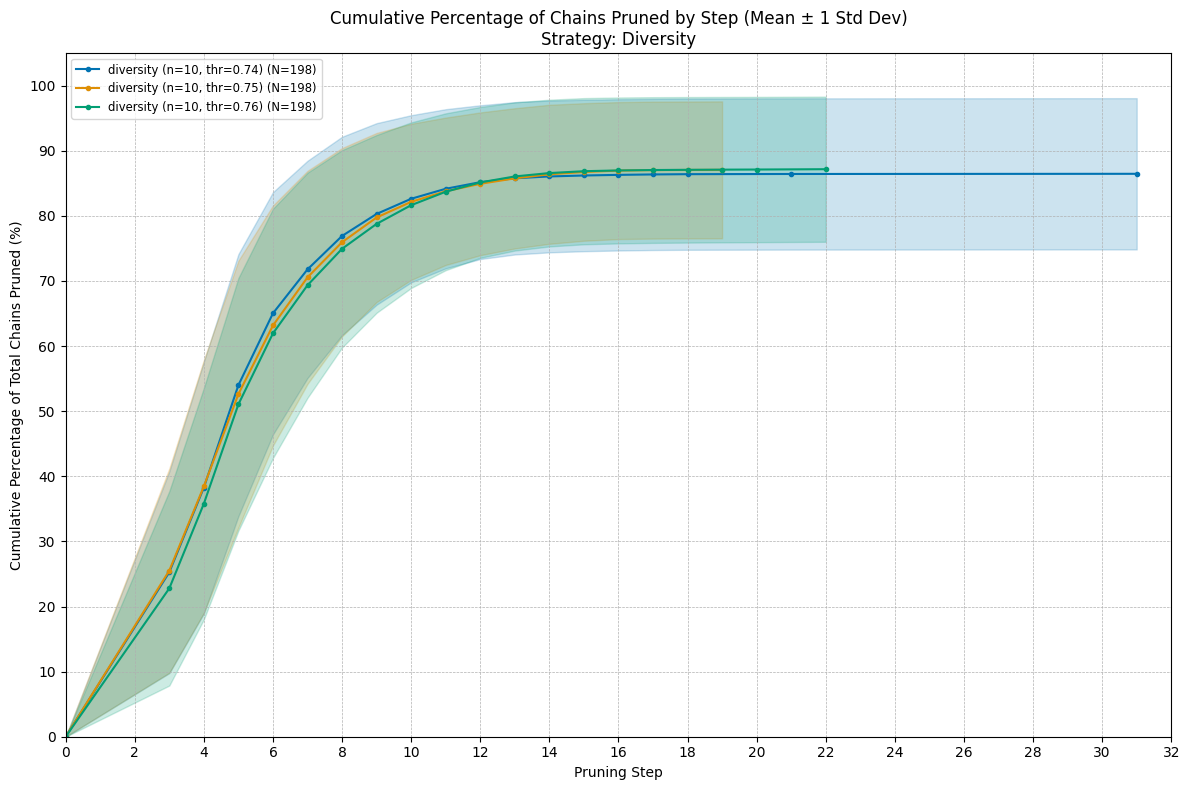


Generating plot for strategy: fewest
  -> Calculated stats for 'fewest (n=10, thr=0.74)' (198 questions).
  -> Calculated stats for 'fewest (n=10, thr=0.75)' (198 questions).
  -> Calculated stats for 'fewest (n=10, thr=0.76)' (198 questions).


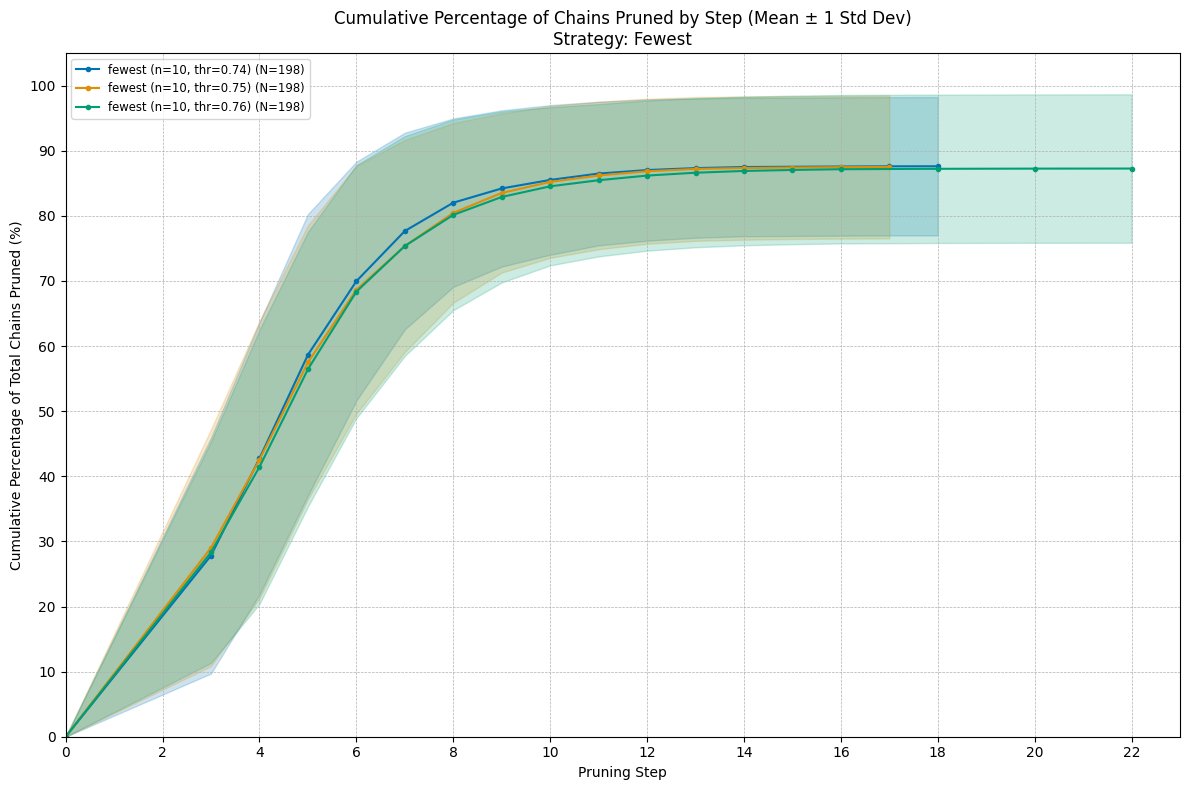


Generating plot for strategy: most
  -> Calculated stats for 'most (n=10, thr=0.74)' (198 questions).
  -> Calculated stats for 'most (n=10, thr=0.75)' (198 questions).
  -> Calculated stats for 'most (n=10, thr=0.76)' (198 questions).


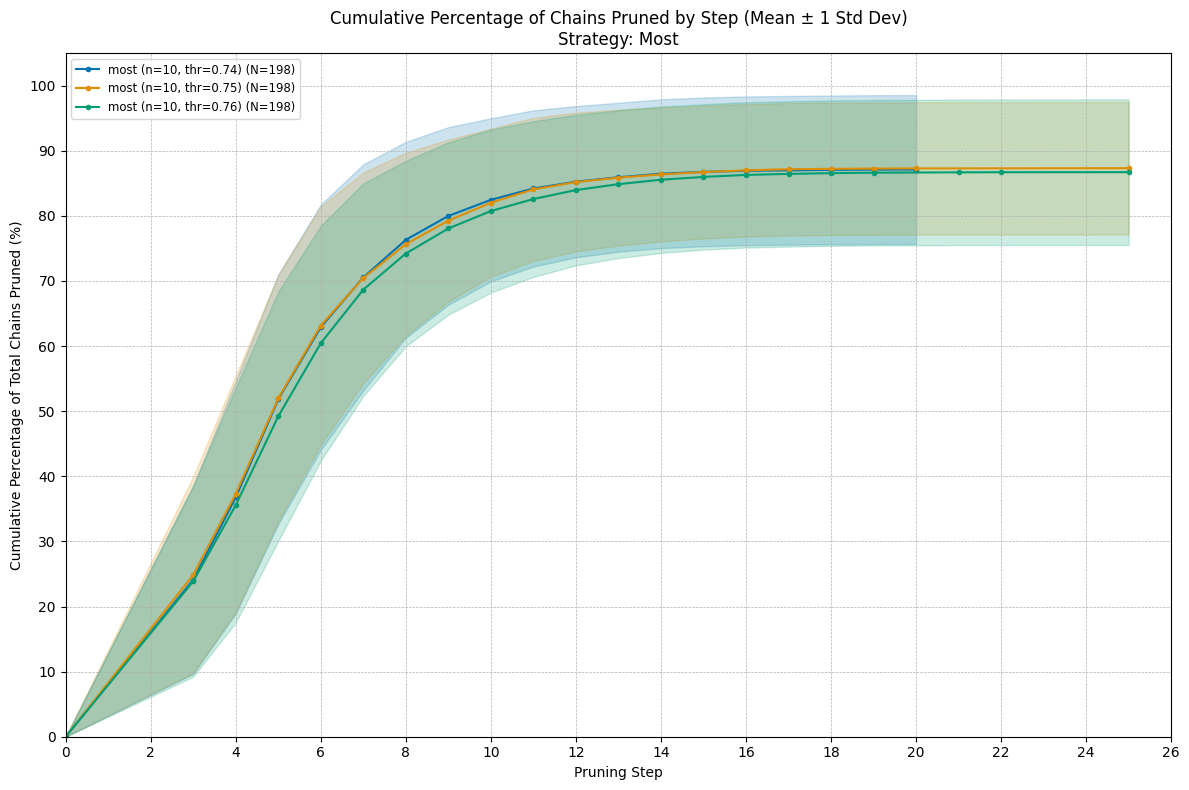


Finished processing all experiments and generating grouped plots with confidence bands.


In [9]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import os
import re
from scipy import interpolate
import seaborn as sns

# --- Helper Function to Parse Experiment Name ---
def parse_experiment_name(dir_name):
    """
    Parses the experiment directory name to extract strategy and parameters.
    Returns a tuple: (strategy, label) or (None, None) if parsing fails.
    """
    parts = dir_name.split('_prune_')
    if len(parts) != 2:
        # Handle cases without '_prune_' like 'baseline_n10'
        if 'baseline' in dir_name:
             strategy = 'baseline'
             label = dir_name # Use full name as label
             return strategy, label
        print(f"  -> Warning: Could not parse strategy from directory name: {dir_name}")
        return None, None

    strategy_and_params = parts[1]
    strategy_parts = strategy_and_params.split('_')
    
    strategy = strategy_parts[0]
    
    params_label_parts = []
    n_match = re.search(r'_n(\d+)', dir_name) # Check full name for n
    if n_match:
        params_label_parts.append(f"n={n_match.group(1)}")
        
    thresh_match = re.search(r'_thresh([\d.]+)', strategy_and_params)
    if thresh_match:
        params_label_parts.append(f"thr={thresh_match.group(1)}")
        
    max_active_match = re.search(r'_max_active(\d+)', strategy_and_params)
    if max_active_match:
         params_label_parts.append(f"max_act={max_active_match.group(1)}")

    if not params_label_parts and len(strategy_parts) > 1:
         params_label_parts.append("_".join(strategy_parts[1:]))
            
    label = f"{strategy} ({', '.join(params_label_parts)})" if params_label_parts else strategy
    label = label.replace('_', ' ') # Make label more readable

    # Map common strategy variations if needed
    if 'diversity' in strategy.lower():
        strategy_key = 'diversity'
    elif 'most_thoughts' in strategy.lower():
         strategy_key = 'most_thoughts'
    elif 'fewest_thoughts' in strategy.lower():
         strategy_key = 'fewest_thoughts'
    elif 'baseline' in strategy.lower():
        strategy_key = 'baseline' # Group baselines together
    else:
         strategy_key = strategy 
        
    return strategy_key, label


# --- Main Script ---

# Define the base directory containing the experiment results
notebook_dir = Path(os.getcwd()) # Assumes notebook is in slimsc/prune/plots/
base_results_dir = notebook_dir.parent / "results" / "R1-Distill-Qwen-14B" / "gpqa_diamond"
# Or define an absolute path:
# base_results_dir = Path("/path/to/your/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond")

print(f"Base results directory: {base_results_dir}")

# Dictionary to hold data grouped by strategy
# Structure: { 'strategy_key': { 'experiment_label': {'per_question_raw': [...], 'details': {...} }, ... }, ... }
grouped_experiment_data = defaultdict(lambda: defaultdict(lambda: {'per_question_raw': [], 'details': {}}))
max_step_overall = 0 # Keep track of the max step across all experiments

if not base_results_dir.is_dir():
    print(f"ERROR: Base results directory not found at {base_results_dir}")
else:
    # --- Data Aggregation Phase ---
    print("\n--- Aggregating data from experiments ---")
    for experiment_dir in sorted(base_results_dir.iterdir()):
        if experiment_dir.is_dir():
            experiment_name = experiment_dir.name
            
            strategy, label = parse_experiment_name(experiment_name)
            if strategy is None:
                continue 

            print(f"\nProcessing experiment: {experiment_name} (Strategy: {strategy}, Label: {label})")
            summaries_dir = experiment_dir / "summaries"

            if not summaries_dir.is_dir():
                print(f"  -> Summaries directory not found: {summaries_dir}")
                continue

            experiment_question_data = [] # Store raw data per question for this experiment
            experiment_all_pruned_steps_union = set() # Unique steps across all questions in this experiment
            experiment_max_step = 0 # Max step within this experiment

            json_files_found = list(summaries_dir.glob("question_*_summary.json"))
            if not json_files_found:
                print(f"  -> No question summary JSON files found in {summaries_dir}")
                continue
                
            processed_files_count = 0
            for json_file in json_files_found:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)

                    n_start = data.get("n_chains_start", 0)
                    if n_start <= 0:
                        # print(f"  -> Skipping {json_file.name}, n_chains_start={n_start}")
                        continue
                        
                    processed_files_count += 1
                    question_pruned_steps = []
                    if "pruned_chain_details" in data:
                        for chain in data["pruned_chain_details"]:
                            if "pruned_at_step" in chain:
                                step = chain["pruned_at_step"]
                                question_pruned_steps.append(step)
                                experiment_all_pruned_steps_union.add(step)
                                experiment_max_step = max(experiment_max_step, step)
                                max_step_overall = max(max_step_overall, step) # Update global max step

                    # Store raw data needed for later CDF calculation per question
                    experiment_question_data.append({
                        'n_start': n_start,
                        'pruned_steps': question_pruned_steps
                    })

                except json.JSONDecodeError:
                    print(f"  -> Error decoding JSON from {json_file.name}")
                except Exception as e:
                    print(f"  -> Error processing file {json_file.name}: {e}")

            if not experiment_question_data:
                 print(f"  -> No valid question data found for experiment {experiment_name}.")
                 continue
                 
            print(f"  -> Processed {processed_files_count} valid summary files.")
            # Store collected data
            grouped_experiment_data[strategy][label]['per_question_raw'] = experiment_question_data
            grouped_experiment_data[strategy][label]['details']['all_steps_union'] = sorted(list(experiment_all_pruned_steps_union))
            grouped_experiment_data[strategy][label]['details']['max_step'] = experiment_max_step
            grouped_experiment_data[strategy][label]['details']['num_questions'] = len(experiment_question_data)
            print(f"  -> Stored data for {len(experiment_question_data)} questions. Max step in exp: {experiment_max_step}")


    # --- Calculation and Plotting Phase ---
    print("\n--- Calculating Statistics and Generating Plots ---")

    for strategy, experiments in grouped_experiment_data.items():
        print(f"\nGenerating plot for strategy: {strategy}")
        
        # Sort experiments by label for consistent plotting order
        sorted_experiment_labels = sorted(experiments.keys())
        
        if not sorted_experiment_labels:
            print(f"  -> No experiments found for strategy '{strategy}'. Skipping.")
            continue

        plt.figure(figsize=(12, 8)) # Slightly larger figure
        group_max_step = 0 # Find max step across all experiments *within this group*
        
        # --- Calculate Aggregated CDFs with Confidence Bands ---
        for label in sorted_experiment_labels:
            exp_data = experiments[label]
            question_raw_data = exp_data['per_question_raw']
            details = exp_data['details']
            
            num_questions = details['num_questions']
            if num_questions == 0:
                print(f"  -> Skipping '{label}': No question data.")
                continue
                
            # Use union of steps within the experiment as the common grid. Add 0.
            # If no steps were recorded at all, use just step 0.
            common_steps = np.array([0] + details['all_steps_union'])
            current_exp_max_step = details['max_step']
            group_max_step = max(group_max_step, current_exp_max_step) # Update group max step

            # Matrix to store interpolated percentages [question, step]
            interpolated_percentages = np.zeros((num_questions, len(common_steps)))

            for i, q_data in enumerate(question_raw_data):
                n_start = q_data['n_start']
                pruned_steps = q_data['pruned_steps']

                if n_start == 0: # Should have been filtered, but double check
                    interpolated_percentages[i, :] = np.nan # Mark as NaN if no chains started
                    continue

                if not pruned_steps:
                    # If no chains were pruned, percentage is 0 at all steps
                    q_plot_steps = np.array([0, current_exp_max_step + 1]) # Define steps up to max
                    q_plot_percentages = np.array([0.0, 0.0])
                else:
                    # Calculate CDF for this specific question
                    step_counts = Counter(pruned_steps)
                    sorted_q_steps = sorted(step_counts.keys())
                    cumulative_counts = np.cumsum([step_counts[step] for step in sorted_q_steps])
                    cumulative_percentage = (cumulative_counts / n_start) * 100
                    
                    # Create step function points (add 0)
                    q_plot_steps = np.array([0] + sorted_q_steps)
                    q_plot_percentages = np.array([0.0] + list(cumulative_percentage))

                    # Ensure the step function extends to the maximum step observed if needed for interpolation later
                    # This might not be strictly necessary if interp handles boundaries correctly, but can be safer
                    if q_plot_steps[-1] < current_exp_max_step:
                         q_plot_steps = np.append(q_plot_steps, current_exp_max_step + 1) # Add a point beyond max
                         q_plot_percentages = np.append(q_plot_percentages, q_plot_percentages[-1]) # Maintain last percentage


                # Interpolate this question's CDF onto the common steps grid for the experiment
                # Using linear interpolation here. For strict step function, logic would be more complex.
                # 'interp1d' with kind='previous' or 'next' might be closer to step func, but linear is common.
                # Using np.interp is simpler and handles boundaries
                # We need to handle cases where q_plot_steps might be empty or have single value if interp fails
                if len(q_plot_steps) > 1:
                    interp_func = interpolate.interp1d(q_plot_steps, q_plot_percentages, kind='linear', bounds_error=False, fill_value=(q_plot_percentages[0], q_plot_percentages[-1]))
                    interpolated_percentages[i, :] = interp_func(common_steps)
                    # Clamp values just in case interpolation goes slightly out of [0, 100] range due to floats
                    interpolated_percentages[i, :] = np.clip(interpolated_percentages[i, :], 0, 100)
                elif len(q_plot_steps) == 1: # Only step 0 (e.g. only unpruned)
                    interpolated_percentages[i, :] = q_plot_percentages[0] # Should be 0
                else: # No steps, likely already handled (n_start=0 or no pruned steps)
                     interpolated_percentages[i, :] = 0.0


            # --- Calculate Mean and Standard Deviation ---
            # Use nanmean/nanstd if we allowed NaNs earlier, otherwise mean/std is fine
            mean_percentages = np.mean(interpolated_percentages, axis=0)
            std_dev_percentages = np.std(interpolated_percentages, axis=0)
            
            # Define bands (e.g., Mean +/- 1 Std Dev)
            lower_band = np.maximum(0, mean_percentages - std_dev_percentages) # Don't go below 0%
            upper_band = np.minimum(100, mean_percentages + std_dev_percentages) # Don't exceed 100%

            # Store calculated stats for plotting
            exp_data['stats'] = {
                'common_steps': common_steps,
                'mean': mean_percentages,
                'lower': lower_band,
                'upper': upper_band,
                'num_questions': num_questions # Store count for potential annotation
            }
            print(f"  -> Calculated stats for '{label}' ({num_questions} questions).")

        # --- Plotting with Confidence Bands ---
        # colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_experiment_labels))) # Get distinct colors
        colors = sns.color_palette('colorblind', n_colors=len(sorted_experiment_labels))

        for i, label in enumerate(sorted_experiment_labels):
            if 'stats' not in experiments[label]:
                continue # Skip if stats calculation failed

            stats = experiments[label]['stats']
            common_steps = stats['common_steps']
            mean_line = stats['mean']
            lower_band = stats['lower']
            upper_band = stats['upper']
            num_q = stats['num_questions']
            
            color = colors[i]
            
            # Plot the mean line
            line, = plt.plot(common_steps, mean_line, marker='.', linestyle='-', label=f"{label} (N={num_q})", color=color)
            
            # Add the confidence band using fill_between
            # Check if there's actually variance to plot band
            if np.any(upper_band > lower_band) and num_q > 1: # Only plot band if std dev > 0 and more than 1 question
                 plt.fill_between(common_steps, lower_band, upper_band, alpha=0.2, color=line.get_color())
            elif num_q <= 1:
                 print(f"  -> Note: Confidence band not shown for '{label}' (only {num_q} question(s)).")


        # --- Final Plot Setup ---
        plt.title(f"Cumulative Percentage of Chains Pruned by Step (Mean ± 1 Std Dev)\nStrategy: {strategy.replace('_', ' ').title()}")
        plt.xlabel("Pruning Step")
        plt.ylabel("Cumulative Percentage of Total Chains Pruned (%)")
        plt.ylim(0, 105) 
        plt.xlim(left=0, right=max(10, group_max_step + 1)) # Use max step from the group
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        tick_step = 2
        plt.xticks(np.arange(0, group_max_step + 2, step=tick_step))
        plt.yticks(np.arange(0, 101, 10))

        plt.legend(loc='best', fontsize='small') # Adjust legend location if needed
        
        plt.tight_layout()
        plt.show()

print("\nFinished processing all experiments and generating grouped plots with confidence bands.")

In [1]:
# Cell 1: Setup and Imports

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from typing import Dict, List, Optional, Any

# Define the base results directory
# Adjust this path if your notebook is located elsewhere relative to the 'results' folder
# Assumes notebook is in slimsc/prune/plots/
# and results are in slimsc/prune/results/
notebook_dir = Path(os.getcwd()) 
results_base_dir = notebook_dir.parent / "results" 

# plots_save_dir is the directory where the notebook is located
plots_save_dir = notebook_dir 

print(f"Notebook directory: {notebook_dir}")
print(f"Scanning for results in: {results_base_dir.resolve()}") # Show resolved path
print(f"Plots will be saved in: {plots_save_dir.resolve()}") # Show resolved path

if not results_base_dir.is_dir():
    print(f"ERROR: Results base directory not found at {results_base_dir.resolve()}")
else:
    print("Results base directory found.")
    
if not plots_save_dir.is_dir():
     print(f"WARNING: Plots save directory not found at {plots_save_dir.resolve()}")
     print("Attempting to create it...")
     try:
         plots_save_dir.mkdir(parents=True, exist_ok=True)
         print("Plots save directory created.")
     except Exception as e:
         print(f"ERROR: Failed to create plots save directory: {e}")
         plots_save_dir = None # Indicate saving is not possible

# Optional: Configure matplotlib for better display in notebooks
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # For higher resolution plots

Notebook directory: /home/users/ntu/chong032/slimsc/prune/visualization
Scanning for results in: /home/users/ntu/chong032/slimsc/prune/results
Plots will be saved in: /home/users/ntu/chong032/slimsc/prune/visualization
Results base directory found.


In [2]:
# Cell 2: Define collect_metrics_data function

def collect_metrics_data(results_dir_path: Path) -> pd.DataFrame:
    """
    Scans the results directory and collects metrics from all aggregated_metrics.json files.
    Only processes directories that contain an aggregated_metrics.json file.
    
    Directory structure expected:
    results/
        model_name_1/
            dataset_1/
                strategy_config_1/
                    aggregated_metrics.json  <-- Looks for this file
                strategy_config_2/
                    aggregated_metrics.json
                ...
            dataset_2/
                ...
        model_name_2/
            ...
    
    Args:
        results_dir_path: Path to the results directory (as a Path object)
        
    Returns:
        DataFrame containing all metrics with model, dataset, and strategy information
    """
    data_rows = []
    
    print(f"Scanning directory for aggregated_metrics.json: {results_dir_path}")
    
    if not results_dir_path.is_dir():
        print(f"Error: Results directory not found at {results_dir_path}")
        return pd.DataFrame()

    # Walk through the directory structure
    # Iterate models -> datasets -> strategies
    for model_dir in sorted(results_dir_path.iterdir()):
        if not model_dir.is_dir():
            continue
            
        model_name = model_dir.name

        for dataset_dir in sorted(model_dir.iterdir()):
            if not dataset_dir.is_dir():
                continue
                
            dataset_name = dataset_dir.name
            
            for strategy_dir in sorted(dataset_dir.iterdir()):
                if not strategy_dir.is_dir():
                    continue
                    
                strategy_name = strategy_dir.name
                metrics_file = strategy_dir / "aggregated_metrics.json"
                
                # --- Crucial check: Only process if the file exists ---
                if metrics_file.exists():
                    print(f"    Found metrics in: {model_name}/{dataset_name}/{strategy_name}")
                    
                    try:
                        with open(metrics_file, 'r') as f:
                            metrics_data = json.load(f)
                            
                        # Create a row with metadata and metrics
                        row = {
                            'model': model_name,
                            'dataset': dataset_name,
                            'strategy': strategy_name,
                            'strategy_path': str(strategy_dir)
                        }
                        
                        # Extract pruning method from the folder name
                        if 'fewest' in strategy_name.lower():
                            row['pruning_method'] = 'fewest_thoughts'
                        elif 'most' in strategy_name.lower():
                            row['pruning_method'] = 'most_thoughts'
                        elif 'diversity' in strategy_name.lower():
                            row['pruning_method'] = 'diversity'
                        elif 'sc_' in strategy_name.lower():
                            # Extract the number from sc_X_control or sc_X variants
                            sc_match = re.search(r'sc_(\d+)', strategy_name.lower())
                            if sc_match:
                                sc_num = sc_match.group(1)
                                row['pruning_method'] = f'sc_control_{sc_num}'
                            else:
                                # If sc_ but no number (e.g. older format or different naming)
                                row['pruning_method'] = 'sc_control' # Generic label
                                print(f"    Warning: SC strategy '{strategy_name}' didn't match sc_(\\d+), using generic 'sc_control'")
                        elif 'baseline' in strategy_name.lower():
                             row['pruning_method'] = 'baseline'
                        else:
                            row['pruning_method'] = 'unknown'
                            print(f"    Warning: Unknown pruning method for strategy: {strategy_name}")
                        
                        # Extract threshold from the folder name
                        # Common formats: _threshX.YY, _X.YY (at the end)
                        # Using raw string r'' for regex pattern
                        threshold_match = re.search(r'thresh(\d+\.?\d*)', strategy_name) # Handles optional decimal
                        if threshold_match:
                            try:
                                row['threshold'] = float(threshold_match.group(1))
                            except ValueError:
                                print(f"    Warning: Could not parse threshold float from 'thresh{threshold_match.group(1)}' in {strategy_name}")
                                row['threshold'] = np.nan # Use NaN for invalid float
                        else:
                            # Fallback for format ending in _X.YY
                            threshold_match_end = re.search(r'_(\d+\.?\d*)$', strategy_name)
                            if threshold_match_end:
                                try:
                                    row['threshold'] = float(threshold_match_end.group(1))
                                except ValueError:
                                     print(f"    Warning: Could not parse threshold float from '_{threshold_match_end.group(1)}' at end of {strategy_name}")
                                     row['threshold'] = np.nan
                            else:
                                # Threshold is not required for all methods (e.g., baseline, SC control)
                                # print(f"    Note: No threshold found for strategy: {strategy_name}")
                                row['threshold'] = np.nan # Use NaN for missing threshold

                        
                        # Handle nested metrics structure
                        if 'metrics' in metrics_data and isinstance(metrics_data['metrics'], dict):
                            # Extract overall_accuracy from nested structure
                            if 'overall_accuracy' in metrics_data['metrics']:
                                try:
                                    # Handle potential nested structure like {"accuracy": value, "count": count}
                                    acc_value = metrics_data['metrics']['overall_accuracy']
                                    if isinstance(acc_value, dict) and 'accuracy' in acc_value:
                                        row['overall_accuracy'] = float(acc_value['accuracy'])
                                    else: # Assume it's a direct value
                                        row['overall_accuracy'] = float(acc_value)

                                except (ValueError, TypeError):
                                    print(f"    Warning: Invalid format for overall_accuracy in {metrics_file}")
                                    row['overall_accuracy'] = np.nan # Use NaN for invalid accuracy
                            else:
                                 print(f"    Warning: 'overall_accuracy' key not found in metrics section for {metrics_file}")
                                 row['overall_accuracy'] = np.nan

                            # Add all other metrics from the nested structure
                            for metric_key, metric_value in metrics_data['metrics'].items():
                                # Avoid overwriting overall_accuracy if already handled
                                if metric_key == 'overall_accuracy': continue

                                # Flatten simple values, store complex as JSON string or string
                                if isinstance(metric_value, (int, float, str, bool)) or metric_value is None:
                                    row[metric_key] = metric_value
                                else:
                                     # Store complex structures as JSON strings for inspection
                                     try:
                                         row[metric_key] = json.dumps(metric_value)
                                     except TypeError:
                                         print(f"    Warning: Could not serialize metric {metric_key} in {metrics_file}")
                                         row[metric_key] = str(metric_value) # Fallback to string

                        else: # Handle case where 'metrics' key is missing or not a dict
                             print(f"    Warning: 'metrics' key missing or not a dictionary in {metrics_file}")
                             # Attempt to find overall_accuracy at top level as fallback
                             if 'overall_accuracy' in metrics_data:
                                 try:
                                     row['overall_accuracy'] = float(metrics_data['overall_accuracy'])
                                     print(f"    Found overall_accuracy at top level.")
                                 except (ValueError, TypeError):
                                     print(f"    Warning: Invalid format for top-level overall_accuracy in {metrics_file}")
                                     row['overall_accuracy'] = np.nan
                             else:
                                 row['overall_accuracy'] = np.nan # Use NaN if accuracy not found

                        # Add select top-level metrics - Convert to numeric where appropriate
                        top_level_keys_to_include = {
                            'n_chains_start': int, 
                            'n_chains_completed': int, 
                            'n_chains_pruned': int, 
                            'n_chains_error': int,
                            'similarity_threshold': float # Capture threshold if present at top level
                        }
                        for key, dtype in top_level_keys_to_include.items():
                            if key in metrics_data:
                                try:
                                    row[key] = dtype(metrics_data[key])
                                except (ValueError, TypeError):
                                    print(f"    Warning: Could not convert top-level metric '{key}' to {dtype.__name__} in {metrics_file}")
                                    row[key] = np.nan # Use NaN for conversion errors

                        # Add raw data if available (e.g., from aggregation script)
                        if 'raw_data' in metrics_data and isinstance(metrics_data['raw_data'], dict):
                             # Example: {'total_chains_started': N, 'pruned_at_steps': [s1, s2, ...]}
                             for raw_key, raw_value in metrics_data['raw_data'].items():
                                  row[f'raw_{raw_key}'] = raw_value # Prefix with 'raw_'


                        data_rows.append(row)
                    except json.JSONDecodeError:
                        print(f"    Error decoding JSON from {metrics_file}")
                    except Exception as e:
                        print(f"    Error processing file {metrics_file}: {e}")
    
    # Create DataFrame from collected data
    if data_rows:
        df = pd.DataFrame(data_rows)
        print(f"\nCollected data from {len(df)} strategy configurations.")
        
        # Clean up potential mixed types in threshold column
        df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
        # Convert common metric columns to numeric, coercing errors to NaN
        metrics_to_numeric = [
            'overall_accuracy',
            'mean_total_completion_tokens_per_question',
            'max_max_kv_cache_usage_across_all_questions_perc',
            'mean_processing_duration_sec_per_question',
            'mean_chains_pruned_perc_per_question' # Often a useful metric
        ]
        for col in metrics_to_numeric:
             if col in df.columns:
                  df[col] = pd.to_numeric(df[col], errors='coerce')

        return df
    else:
        print("\nNo metrics data found with aggregated_metrics.json files.")
        return pd.DataFrame()

In [3]:
# Cell 3: Define save_metrics_data function (Optional)

def save_metrics_data(df: pd.DataFrame, output_file: str = "metrics_summary.csv", save_dir: Optional[Path] = None) -> None:
    """
    Saves the collected metrics data to a CSV file.
    
    Args:
        df: DataFrame containing the metrics data
        output_file: Base name for the CSV file
        save_dir: Optional directory path (as a Path object) to save the file.
                  If None, saves in the current working directory.
    """
    if df.empty:
        print("No data to save")
        return
        
    if save_dir:
        output_path = save_dir / output_file
        # Ensure the directory exists before saving
        output_path.parent.mkdir(parents=True, exist_ok=True)
    else:
        output_path = Path(output_file) # Save in current working dir if no base path given

    try:
        df.to_csv(output_path, index=False)
        print(f"Metrics data saved to {output_path}")
    except Exception as e:
        print(f"Error saving data to {output_path}: {e}")

In [4]:
# Cell 3: Define save_metrics_data function

def save_metrics_data(df: pd.DataFrame, output_file: str = "metrics_summary.csv", save_dir: Optional[Path] = None) -> None:
    """
    Saves the collected metrics data to a CSV file.
    
    Args:
        df: DataFrame containing the metrics data
        output_file: Base name for the CSV file
        save_dir: Optional directory path (as a Path object) to save the file.
                  If None, saves in the current working directory.
    """
    if df.empty:
        print("No data to save")
        return
        
    if save_dir:
        output_path = save_dir / output_file
        # Ensure the directory exists before saving
        output_path.parent.mkdir(parents=True, exist_ok=True)
    else:
        output_path = Path(output_file) # Save in current working dir if no base path given

    try:
        df.to_csv(output_path, index=False)
        print(f"Metrics data saved to {output_path}")
    except Exception as e:
        print(f"Error saving data to {output_path}: {e}")

In [5]:
# Cell 4: Define Generic Plotting Function (plot_metric_vs_threshold)

def plot_metric_vs_threshold(df: pd.DataFrame, 
                             metric_col: str,
                             metric_label: str,
                             model_name: Optional[str] = None, 
                             dataset_name: Optional[str] = None,
                             save_base_dir: Optional[Path] = None,
                             plot_file_prefix: str = "metric") -> None:
    """
    Creates a plot showing a specified metric vs threshold for different pruning methods.
    Filters the data by model and dataset.
    
    Args:
        df: DataFrame containing the metrics data
        metric_col: The column name of the metric to plot on the y-axis.
        metric_label: The label for the y-axis (e.g., "Mean Completion Tokens").
        model_name: Optional filter for a specific model.
        dataset_name: Optional filter for a specific dataset.
        save_base_dir: Optional base directory path (as a Path object) to infer
                       a save path.
        plot_file_prefix: Prefix for the saved plot filename (e.g., "accuracy", "completion_tokens").
    """
    if df.empty:
        print(f"No data to plot {metric_label} vs Threshold for {model_name}/{dataset_name}.")
        return
    
    # Filter data if model or dataset specified
    plot_df = df.copy()
    if model_name:
        plot_df = plot_df[plot_df['model'] == model_name]
    if dataset_name:
        plot_df = plot_df[plot_df['dataset'] == dataset_name]
    
    if plot_df.empty:
        print(f"No data found for plotting {metric_label} vs Threshold after filtering for model='{model_name}', dataset='{dataset_name}'")
        return

    # Check for required columns
    required_cols = ['threshold', 'pruning_method', metric_col]
    if not all(col in plot_df.columns for col in required_cols):
        print(f"Missing required columns {required_cols} in filtered data for plotting {metric_label}.")
        print(f"Available columns: {plot_df.columns.tolist()}")
        return

    # Ensure metric and threshold (if not None) are numeric
    plot_df[metric_col] = pd.to_numeric(plot_df[metric_col], errors='coerce')
    plot_df['threshold'] = pd.to_numeric(plot_df['threshold'], errors='coerce')
    
    # Drop rows with missing metric values
    if plot_df[metric_col].isna().any():
        na_count = plot_df[metric_col].isna().sum()
        # print(f"Warning: Dropping {na_count} rows with missing '{metric_col}' values for {model_name}/{dataset_name}") # Verbose
        plot_df = plot_df.dropna(subset=[metric_col])

    if plot_df.empty:
        print(f"No data with valid '{metric_col}' values to plot for {model_name}/{dataset_name}.")
        return

    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Separate methods that use a threshold from non-threshold methods
    threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity']
    # Require threshold to be non-NaN for threshold methods
    similarity_df = plot_df[plot_df['pruning_method'].isin(threshold_methods)].dropna(subset=['threshold']) 

    # Non-threshold methods (baselines, SC control) - threshold can be NaN here
    non_threshold_df = plot_df[~plot_df['pruning_method'].isin(threshold_methods)]
    
    # Plot horizontal lines for non-threshold methods (SC control, baseline)
    non_threshold_methods_list = sorted(non_threshold_df['pruning_method'].unique()) # Sort for consistent color assignment
    # Get enough colors for non-threshold methods
    non_threshold_colors = plt.cm.tab10(np.linspace(0, 1, max(1, len(non_threshold_methods_list)))) 

    for i, method in enumerate(non_threshold_methods_list):
        method_df = non_threshold_df[non_threshold_df['pruning_method'] == method]
        if not method_df.empty:
            # If there are multiple entries for a non-threshold method, average the metric
            method_metric_mean = method_df[metric_col].mean()
            is_sc_control = method.startswith('sc_control') 

            if is_sc_control and metric_col != 'overall_accuracy':
                 # Skip plotting this horizontal line
                 # print(f"  Skipping plotting SC Control line '{method}' for {metric_label} plot.") # Optional debug
                 continue # Move to the next iteration of the loop

            color = non_threshold_colors[i]
            
            # Use the original strategy name for the label if unique, otherwise the method name
            unique_strategies = method_df['strategy'].unique()
            if len(unique_strategies) == 1:
                 label = f'{unique_strategies[0]}: {method_metric_mean:.2f}'
            else:
                 label = f'{method.replace("_", " ").title()} (N={len(method_df)}): {method_metric_mean:.2f}'
            
            plt.axhline(y=method_metric_mean, color=color, 
                       linestyle='--', label=label, alpha=0.7)


    # Plot threshold methods as lines
    if not similarity_df.empty:
        # Define colors for similarity methods (distinct from non-threshold colors if possible)
        sim_methods_list = ['fewest_thoughts', 'most_thoughts', 'diversity'] # Define order
        # Filter to only include methods actually present in the data
        sim_methods_present = [m for m in sim_methods_list if m in similarity_df['pruning_method'].unique()]
        # Get enough colors for similarity methods
        sim_colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(sim_methods_present)))) 


        for i, method in enumerate(sim_methods_present):
            method_df = similarity_df[similarity_df['pruning_method'] == method]
            if not method_df.empty:
                # Group by threshold and calculate mean metric
                grouped = method_df.groupby('threshold')[metric_col].mean().reset_index()
                # Sort by threshold for proper line plot
                grouped = grouped.sort_values('threshold')
                
                # Format method name for display
                display_name = method.replace('_', ' ').title()
                
                # Refined Label
                label = f'{display_name} ({len(method_df)} configs)' # Indicate number of configs

                color = sim_colors[i]
                
                plt.plot(grouped['threshold'], grouped[metric_col], 
                        marker='o', linestyle='-', color=color, 
                        label=label)

    # Add labels and title
    model_title = f"Model: {model_name}" if model_name else "All Models"
    dataset_title = f"Dataset: {dataset_name}" if dataset_name else "All Datasets"
    plt.title(f'{metric_label} vs Threshold for Pruning Methods\n{model_title}, {dataset_title}')
    plt.xlabel('Threshold')
    plt.ylabel(metric_label)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize='small')
    
    # --- Adjust X-axis (Threshold) ---
    # Find min/max threshold values from the similarity methods for x-axis range
    min_thresh = similarity_df['threshold'].min()
    max_thresh = similarity_df['threshold'].max()

    # Ensure thresholds are numeric before checking nan/inf
    min_thresh = pd.to_numeric(min_thresh, errors='coerce')
    max_thresh = pd.to_numeric(max_thresh, errors='coerce')

    if pd.notna(min_thresh) and pd.notna(max_thresh):
         # Add 5% padding to the range
         padding = (max_thresh - min_thresh) * 0.05
         plt.xlim(left=max(0, min_thresh - padding), right=max_thresh + padding) 
         
         # Set x-ticks with 0.02 interval
         # Start from the minimum threshold, go up to max + a little bit to ensure max is included
         x_ticks_start = min_thresh 
         x_ticks_end = max_thresh + 0.005 # Add small value to ensure max is included
         x_ticks = np.arange(x_ticks_start, x_ticks_end, 0.02)
         # Filter ticks to only include values >= 0
         x_ticks = x_ticks[x_ticks >= 0]
         plt.xticks(x_ticks)
    else:
         # If no threshold data, set default xlim and x_ticks
         plt.xlim(left=0, right=1.0) # Default range if no threshold data
         plt.xticks(np.arange(0, 1.01, 0.1))


    # --- Adjust Y-axis (Metric) ---
    # Find min/max metric values to set y-axis limits.
    # Exclude SC Control methods for non-accuracy plots.

    # Start with all relevant data points
    all_metrics_data = plot_df[metric_col].dropna()

    metrics_for_ylim = all_metrics_data # Default: use all data

    if metric_col != 'overall_accuracy':
        # If it's not the accuracy plot, exclude SC Control methods from Y-limit calculation
        
        # Find rows that are NOT SC control methods
        non_sc_control_data = plot_df[~plot_df['pruning_method'].str.startswith('sc_control')]
        
        # Get the metric values from these rows and drop NaNs
        metrics_for_ylim = non_sc_control_data[metric_col].dropna()

    # Now use metrics_for_ylim for calculating min/max
    if not metrics_for_ylim.empty:
        min_met = metrics_for_ylim.min()
        max_met = metrics_for_ylim.max()
        
        # Calculate range and add padding
        met_range = max_met - min_met
        # Add a minimum range if all values are the same
        if met_range == 0:
             # Add 10% or at least 1 unit if values are identical. Ensure y_upper > y_lower
             padding = max(abs(min_met) * 0.1, 1.0) 
             y_lower = min_met - padding/2
             y_upper = min_met + padding/2
        else:
            padding = met_range * 0.1 # 10% padding
            # Ensure y-axis starts sensibly (can start at 0 if appropriate for the metric)
            y_lower = min_met - padding
            y_upper = max_met + padding


        # Specific adjustments based on metric type if needed (keep these)
        if metric_col == 'overall_accuracy':
             y_lower = max(0.0, y_lower) # Accuracy doesn't go below 0
             y_upper = min(1.0, y_upper) # Accuracy doesn't exceed 1
        elif metric_col in ['mean_total_completion_tokens_per_question', 
                            'max_max_kv_cache_usage_across_all_questions_perc',
                            'mean_processing_duration_sec_per_question',
                           'mean_chains_pruned_perc_per_question']: 
             y_lower = max(0.0, y_lower) # These metrics are non-negative
             if metric_col == 'max_max_kv_cache_usage_across_all_questions_perc':
                  y_upper = min(100.0, y_upper) # KV cache % doesn't exceed 100
             if metric_col == 'mean_chains_pruned_perc_per_question':
                  y_upper = min(100.0, y_upper) # Chains pruned % doesn't exceed 100

        # Final check to ensure y_lower is strictly less than y_upper if possible
        if y_lower >= y_upper:
             y_upper = y_lower + 1 # Ensure at least a minimal range

        plt.ylim(y_lower, y_upper)

    else:
        # Handle case where metrics_for_ylim is empty (e.g., no relevant data found for plotting)
        print(f"  Warning: No relevant data found for setting Y-axis limits for {metric_label}. Using default limits.")
        # Let matplotlib decide or set a generic default
        # plt.ylim(0, 100) # Example default; letting matplotlib choose is often best here


    # Generate a filename based on metric, model, dataset, and base save directory
    plot_filename = f"{plot_file_prefix}_vs_threshold"
    if model_name: plot_filename += f"_{model_name}"
    if dataset_name: plot_filename += f"_{dataset_name}"
    plot_filename += ".png"
    
    # Use the provided save_base_dir (plots directory)
    if save_base_dir and save_base_dir.is_dir():
        plot_save_path = save_base_dir / plot_filename
        # Ensure the directory exists (should be handled in Cell 1, but double-check)
        plot_save_path.parent.mkdir(parents=True, exist_ok=True) 
    else:
         # Fallback if save_base_dir is invalid
         print("Error: Invalid save_base_dir provided. Saving plot to current working directory.")
         plot_save_path = Path(plot_filename) # Save in current working dir


    
    # Save the plot
    try:
        plt.tight_layout()
        plt.savefig(plot_save_path, dpi=300)
        print(f"  Plot saved to {plot_save_path.resolve()}") # Show resolved path
    except Exception as e:
        print(f"  Error saving plot to {plot_save_path.resolve()}: {e}")
    
    # Display the plot
    plt.show()

In [6]:
# Cell 5: Collect Metrics Data

# Check if the base results directory was found in Cell 1
if results_base_dir.is_dir():
    metrics_df = collect_metrics_data(results_base_dir)
    
    # Display collected data info (using display() for notebooks)
    print("\n--- Collected Metrics Data Summary ---")
    print(f"DataFrame shape: {metrics_df.shape}")
    if not metrics_df.empty:
        print("First 5 rows:")
        display(metrics_df.head()) 
        print("\nColumns:", metrics_df.columns.tolist())
        print("\nInfo:")
        metrics_df.info()
        
        # Optional: Look at unique models, datasets, methods, and thresholds
        print("\nUnique Models:", metrics_df['model'].unique())
        print("Unique Datasets:", metrics_df['dataset'].unique())
        print("Unique Pruning Methods:", metrics_df['pruning_method'].unique())
        
        # Display unique thresholds for threshold-based methods
        threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity']
        threshold_data = metrics_df[metrics_df['pruning_method'].isin(threshold_methods)]
        if not threshold_data.empty:
             print("Unique Thresholds for threshold methods:", sorted(threshold_data['threshold'].dropna().unique()))

    else:
        print("DataFrame is empty. No data collected.")
else:
     metrics_df = pd.DataFrame() # Ensure df exists even if dir not found
     print("Cannot collect data, results directory not found in Cell 1.")

# Optional: Save the collected data to CSV
# if not metrics_df.empty and plots_save_dir and plots_save_dir.is_dir():
#     save_metrics_data(metrics_df, output_file="metrics_summary.csv", save_dir=plots_save_dir)

Scanning directory for aggregated_metrics.json: /home/users/ntu/chong032/slimsc/prune/results
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.60
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.70
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.75
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.80
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/diversity_n10_thresh0.90
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/fewest_thoughts_n10_thresh0.60
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/fewest_thoughts_n10_thresh0.70
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/fewest_thoughts_n10_thresh0.75
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/fewest_thoughts_n10_thresh0.80
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/fewest_thoughts_n10_thresh0.90
    Found metrics in: R1-Distill-Qwen-14B/gpqa_diamond/most_thoughts_n10_thr

,model,dataset,strategy,strategy_path,pruning_method,threshold,overall_accuracy,num_qns_processed,num_qns_with_score,mean_total_completion_tokens_per_question,...,max_processing_duration_sec_per_question,mean_chains_started_per_question,mean_chains_completed_stream_for_voting_per_question,mean_chains_error_per_question,max_chains_error_per_question,num_questions_processed,num_questions_with_score,mean_chains_requested_per_question,mean_chains_received_per_question,counted_tokens_aggregated
0,R1-Distill-Qwen-14B,gpqa_diamond,diversity_n10_thresh0.60,/home/users/ntu/chong032/slimsc/prune/results/...,diversity,0.60,0.74,50.0,50.0,11214.88,...,319.787977,10.0,1.14,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,R1-Distill-Qwen-14B,gpqa_diamond,diversity_n10_thresh0.70,/home/users/ntu/chong032/slimsc/prune/results/...,diversity,0.70,0.72,50.0,50.0,11665.62,...,284.44555,10.0,1.12,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,R1-Distill-Qwen-14B,gpqa_diamond,diversity_n10_thresh0.75,/home/users/ntu/chong032/slimsc/prune/results/...,diversity,0.75,0.68,50.0,50.0,12281.38,...,331.661162,10.0,1.26,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,R1-Distill-Qwen-14B,gpqa_diamond,diversity_n10_thresh0.80,/home/users/ntu/chong032/slimsc/prune/results/...,diversity,0.80,0.70,50.0,50.0,13092.84,...,303.667574,10.0,1.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,R1-Distill-Qwen-14B,gpqa_diamond,diversity_n10_thresh0.90,/home/users/ntu/chong032/slimsc/prune/results/...,diversity,0.90,0.70,50.0,50.0,23348.00,...,251.709103,10.0,2.78,0.0,0.0,NaN,NaN,NaN,NaN,NaN



Columns: ['model', 'dataset', 'strategy', 'strategy_path', 'pruning_method', 'threshold', 'overall_accuracy', 'num_qns_processed', 'num_qns_with_score', 'mean_total_completion_tokens_per_question', 'max_total_completion_tokens_per_question', 'mean_max_kv_cache_usage_per_question_perc', 'max_max_kv_cache_usage_across_all_questions_perc', 'mean_processing_duration_sec_per_question', 'max_processing_duration_sec_per_question', 'mean_chains_started_per_question', 'mean_chains_completed_stream_for_voting_per_question', 'mean_chains_error_per_question', 'max_chains_error_per_question', 'num_questions_processed', 'num_questions_with_score', 'mean_chains_requested_per_question', 'mean_chains_received_per_question', 'counted_tokens_aggregated']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 24 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                -


--- Generating Plots per Model/Dataset ---

--- Generating plots for Model: R1-Distill-Qwen-14B, Dataset: gpqa_diamond ---

  Generating plot: Accuracy vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/accuracy_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


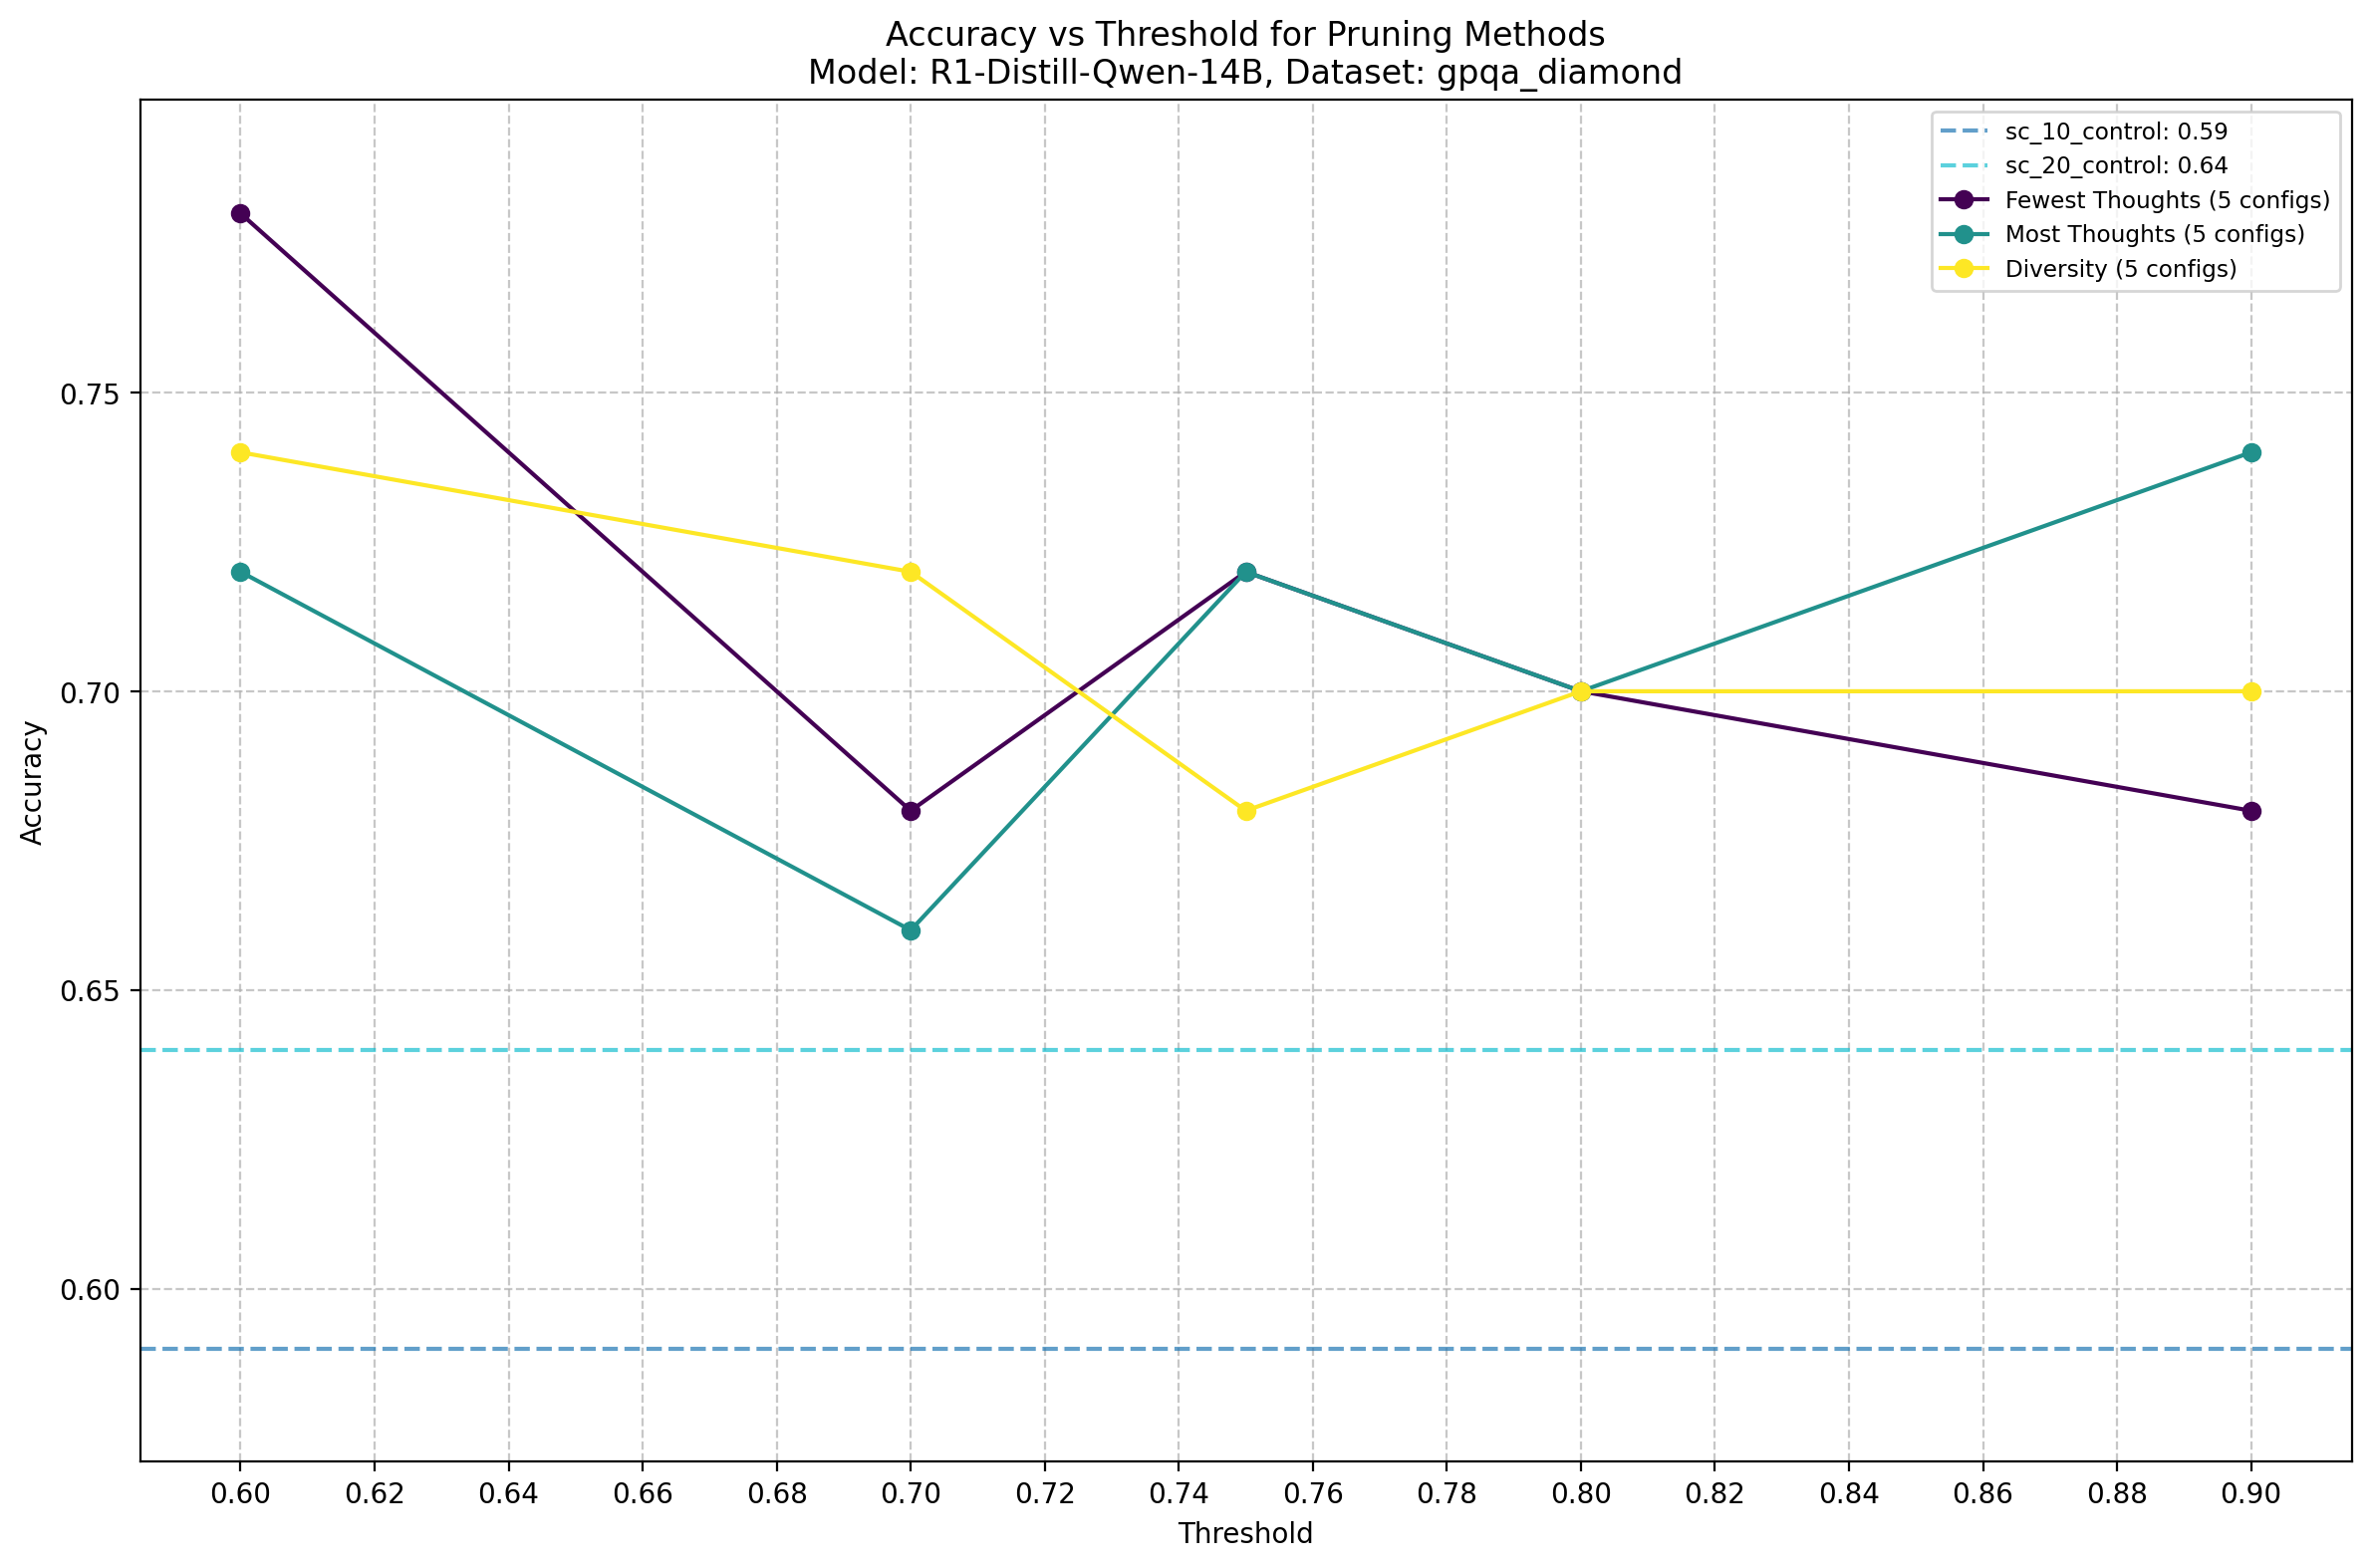


  Generating plot: Mean Completion Tokens vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/completion_tokens_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


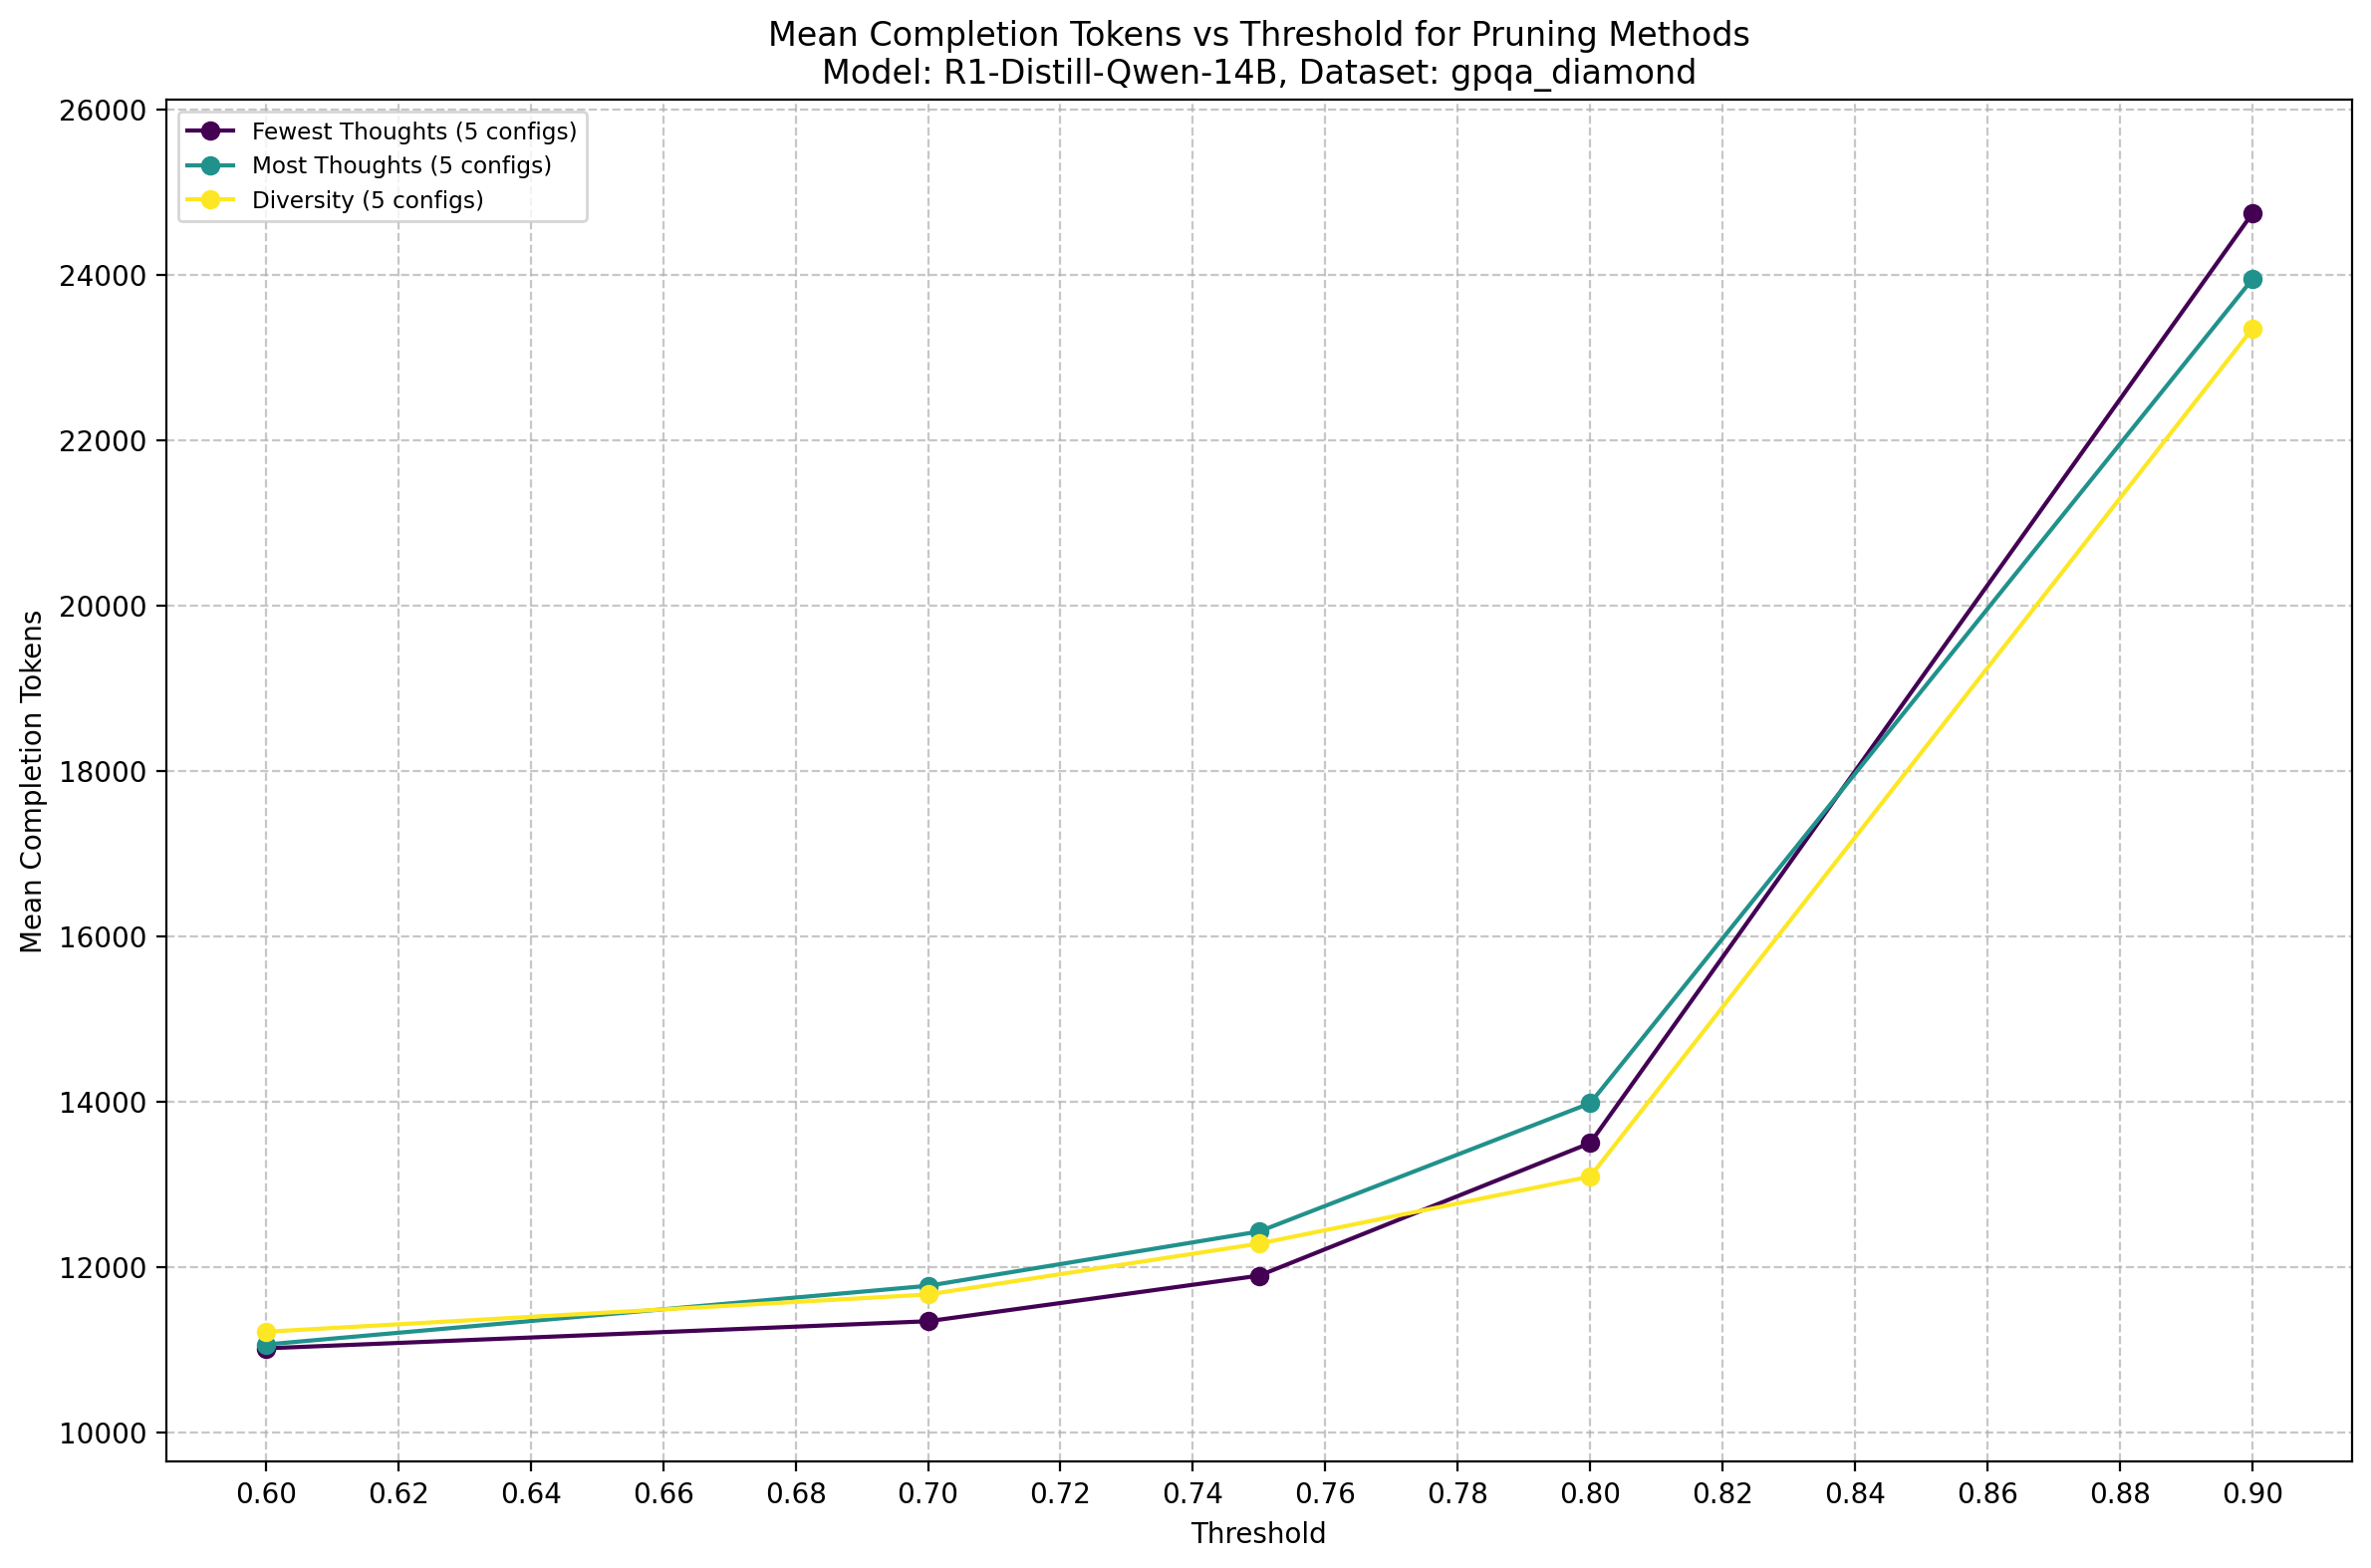


  Generating plot: Max Peak KV Cache Usage (%) vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/kv_cache_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


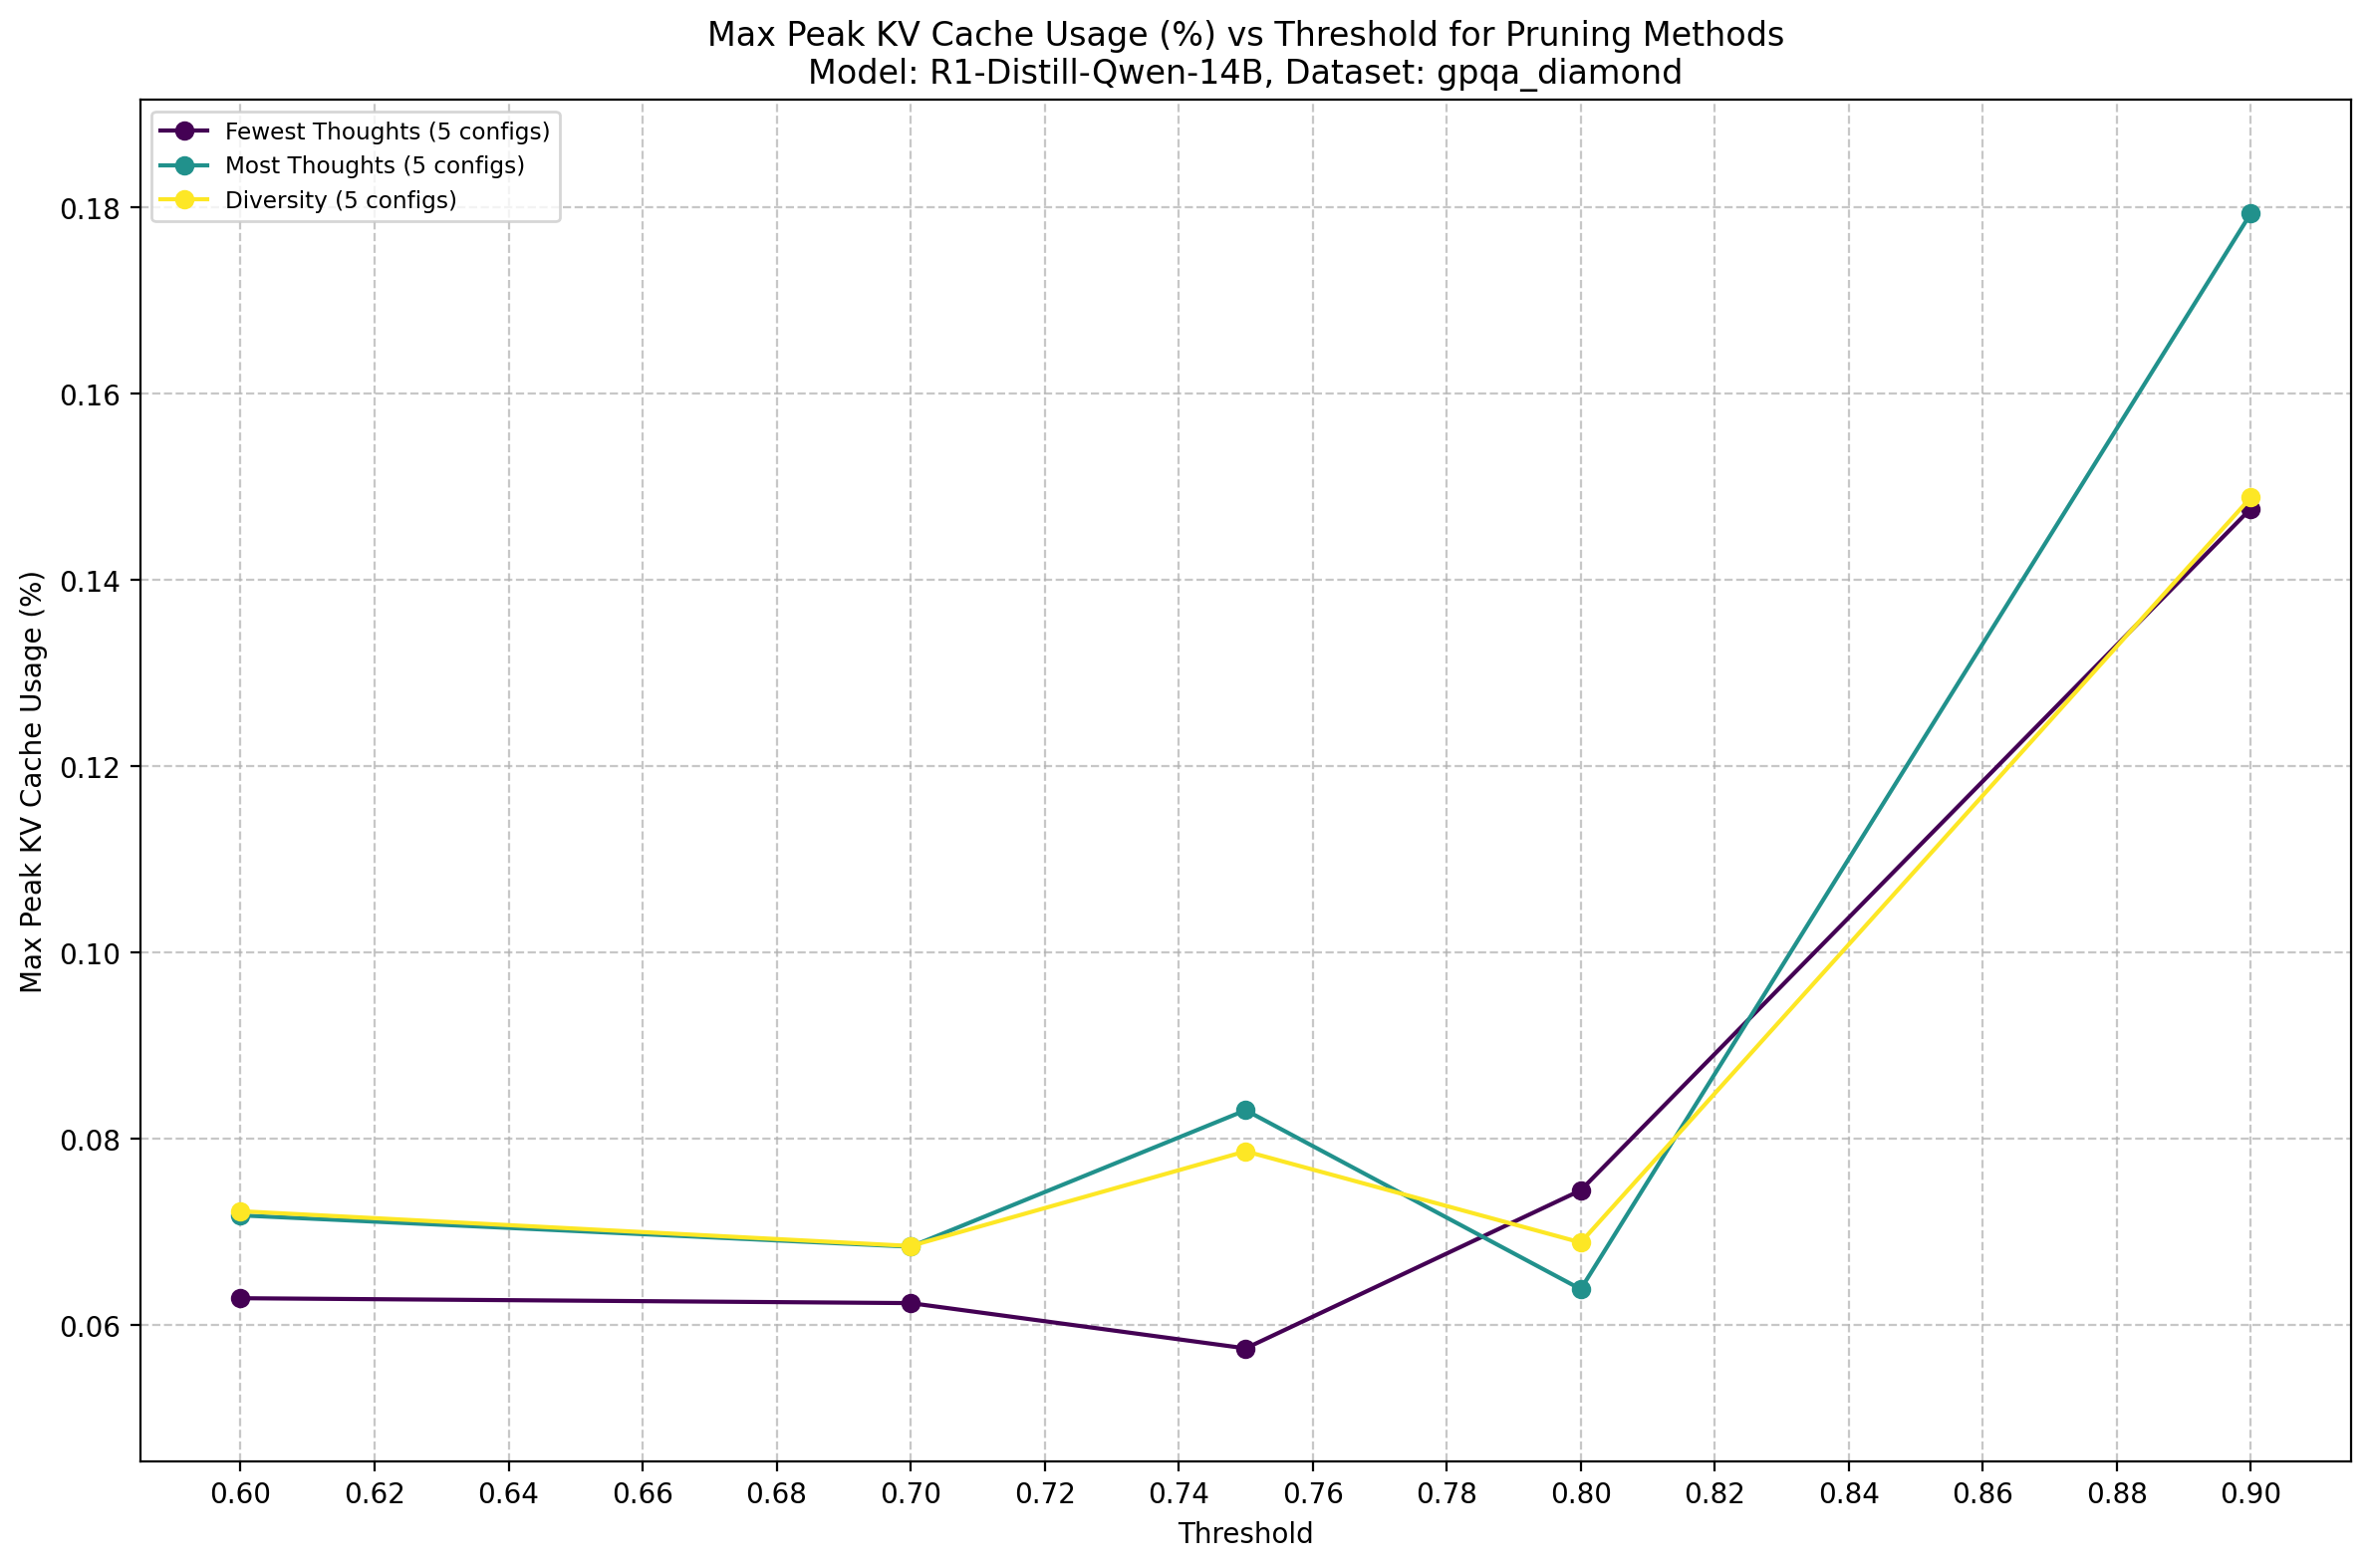


  Generating plot: Mean Processing Time (sec) vs Threshold
  Plot saved to /home/users/ntu/chong032/slimsc/prune/visualization/processing_time_vs_threshold_R1-Distill-Qwen-14B_gpqa_diamond.png


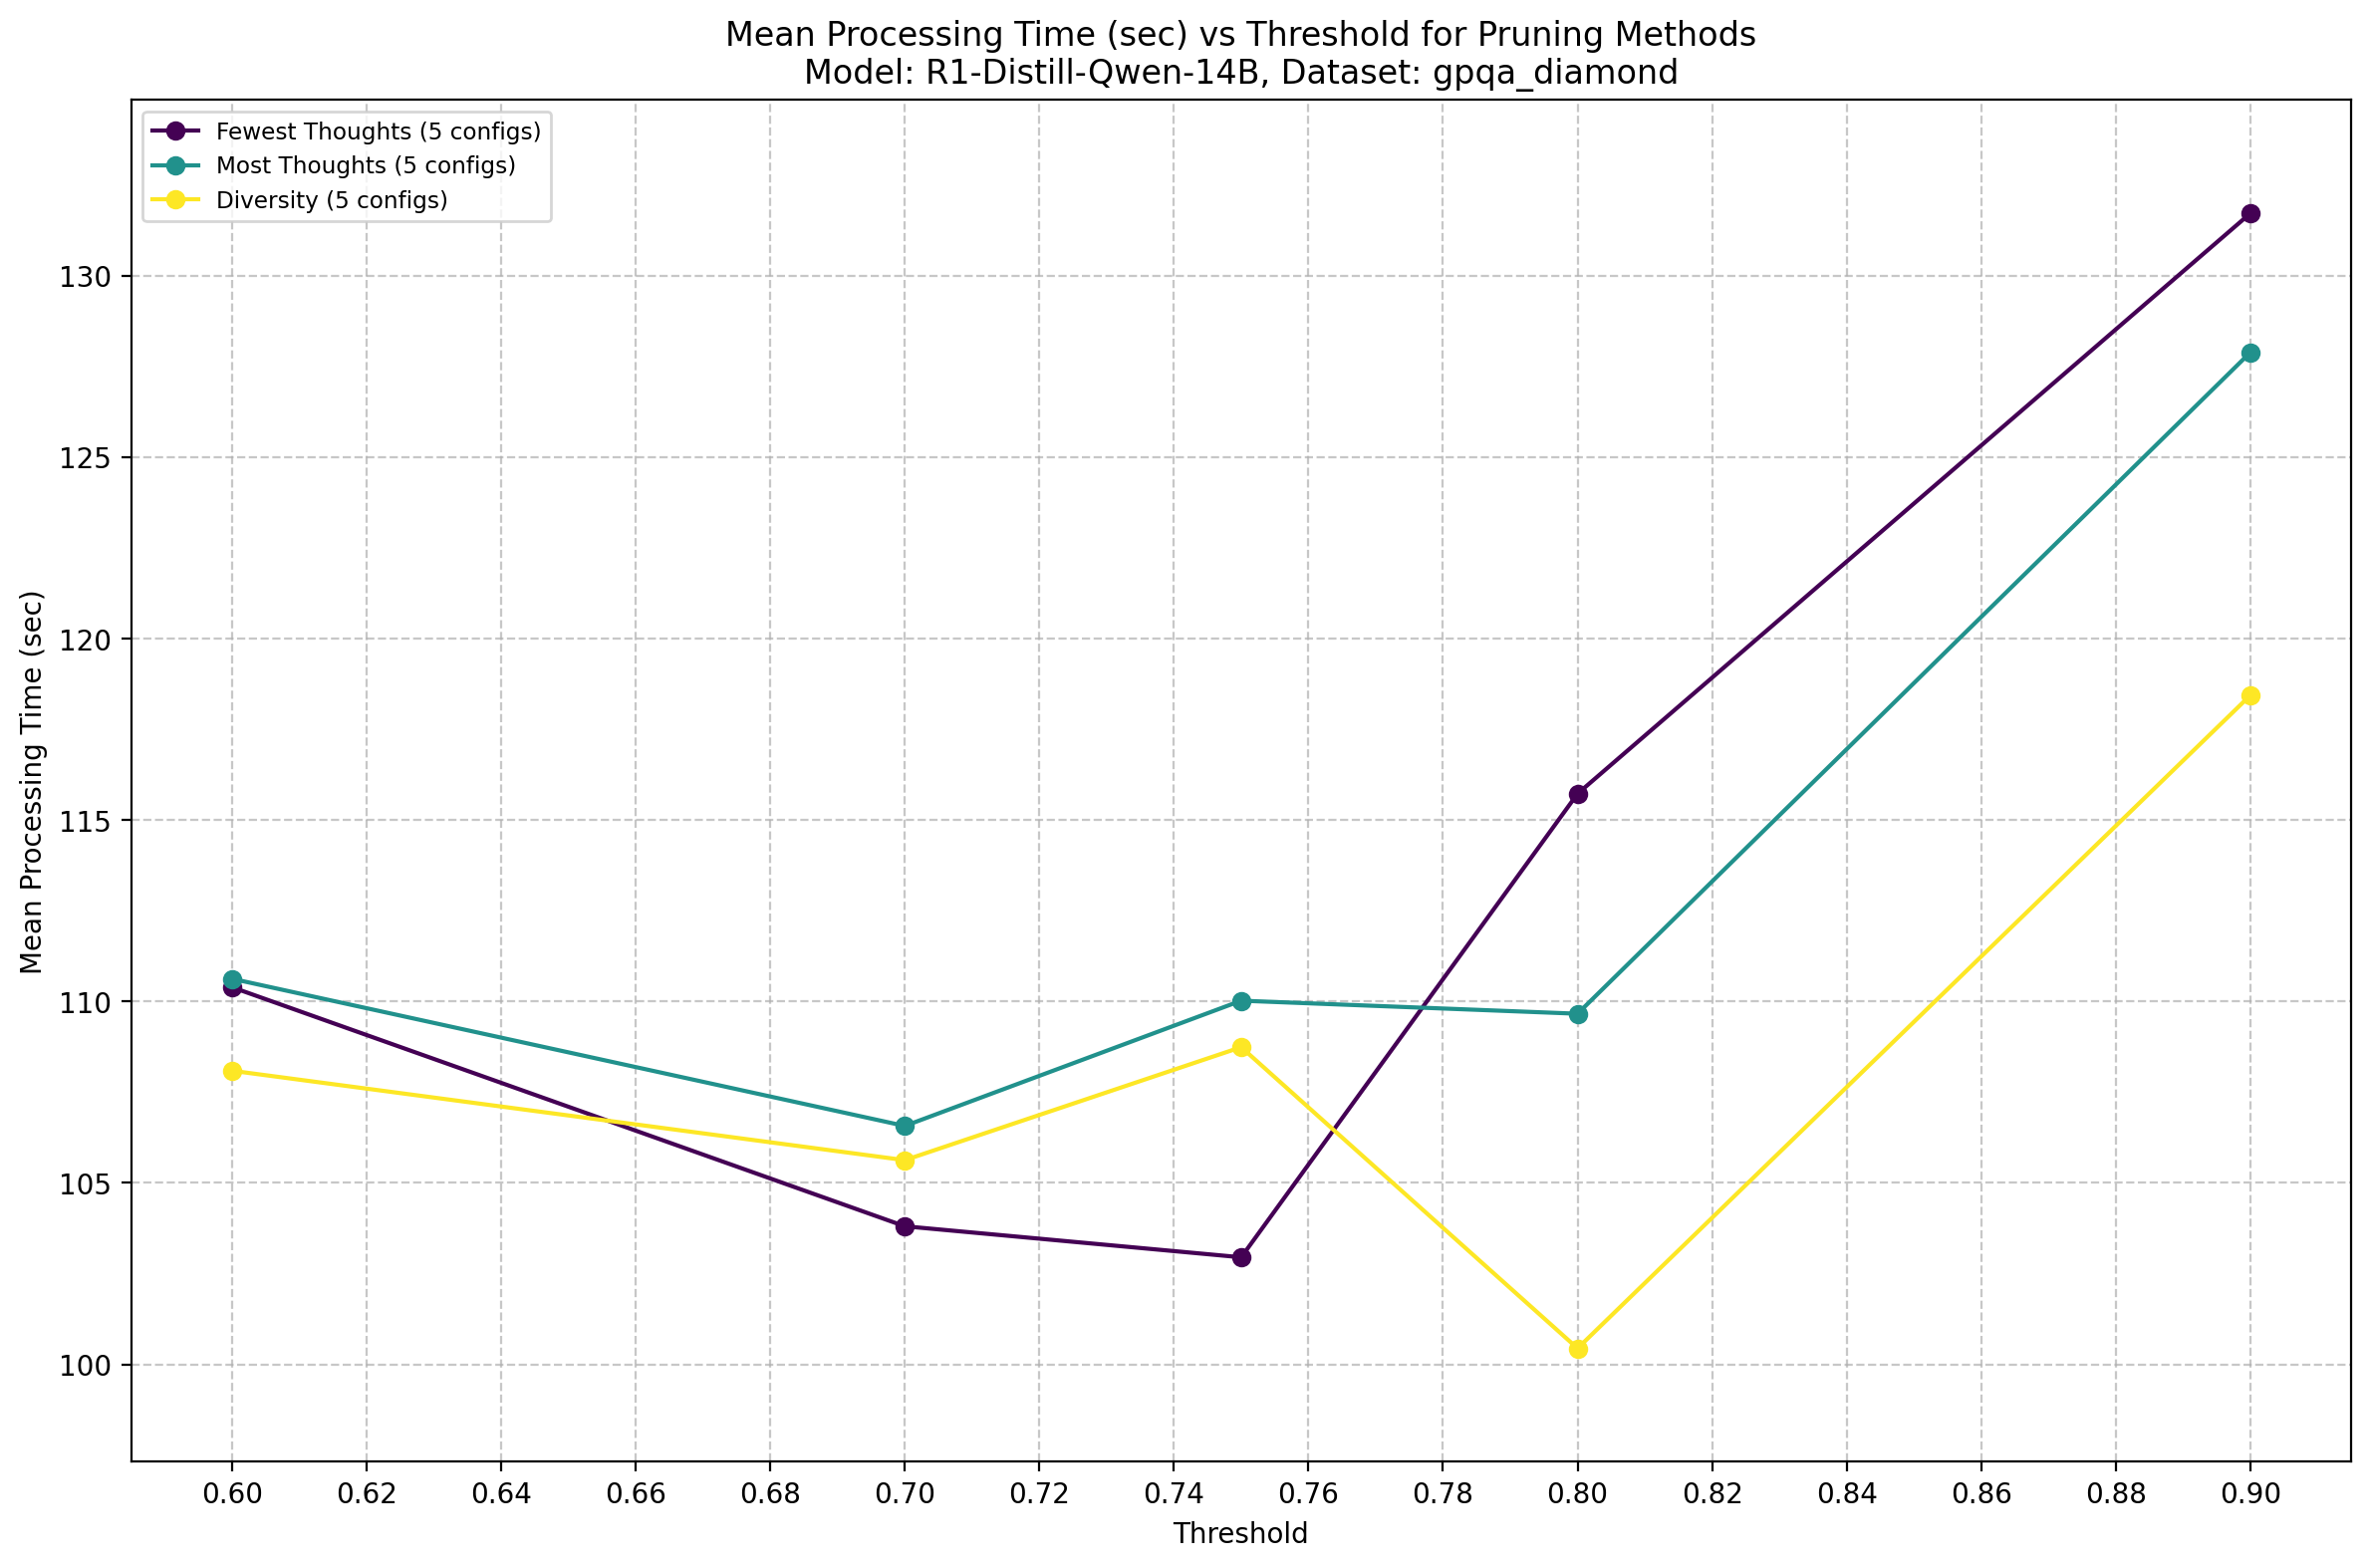

  Skipping plot 'Mean Chains Pruned (%) vs Threshold' for Model: R1-Distill-Qwen-14B, Dataset: gpqa_diamond. Metric column 'mean_chains_pruned_perc_per_question' not found or is empty.


In [7]:
# Cell 6: Generate Plots

# Generate plots for each unique model/dataset combination found in the data
if not metrics_df.empty and plots_save_dir and plots_save_dir.is_dir(): # Ensure plots_save_dir is valid
    unique_models = metrics_df['model'].unique()
    unique_datasets = metrics_df['dataset'].unique()
    
    print("\n--- Generating Plots per Model/Dataset ---")
    
    # Define the metrics to plot
    metrics_to_plot = [
        ('overall_accuracy', 'Accuracy', 'accuracy'),
        ('mean_total_completion_tokens_per_question', 'Mean Completion Tokens', 'completion_tokens'),
        ('max_max_kv_cache_usage_across_all_questions_perc', 'Max Peak KV Cache Usage (%)', 'kv_cache'),
        ('mean_processing_duration_sec_per_question', 'Mean Processing Time (sec)', 'processing_time'),
        ('mean_chains_pruned_perc_per_question', 'Mean Chains Pruned (%)', 'chains_pruned_perc') # Add this one too
    ]

    for model in unique_models:
        for dataset in unique_datasets:
            print(f"\n--- Generating plots for Model: {model}, Dataset: {dataset} ---")
            
            # Filter data once for the current model/dataset
            current_df = metrics_df[(metrics_df['model'] == model) & (metrics_df['dataset'] == dataset)].copy()

            if current_df.empty:
                 print(f"No data for Model: {model}, Dataset: {dataset}. Skipping plots.")
                 continue

            # Check if any threshold data exists before trying to plot threshold vs metric
            threshold_methods = ['fewest_thoughts', 'most_thoughts', 'diversity']
            has_threshold_data = not current_df[current_df['pruning_method'].isin(threshold_methods)].dropna(subset=['threshold']).empty

            if not has_threshold_data:
                 print(f"Note: No threshold-based data found for Model: {model}, Dataset: {dataset}. Only plotting non-threshold methods as horizontal lines where applicable.")


            for metric_col, metric_label, plot_file_prefix in metrics_to_plot:
                # Check if the required metric column exists in the data *for this combination*
                if metric_col not in current_df.columns or current_df[metric_col].dropna().empty:
                    print(f"  Skipping plot '{metric_label} vs Threshold' for Model: {model}, Dataset: {dataset}. Metric column '{metric_col}' not found or is empty.")
                    continue
                    
                print(f"\n  Generating plot: {metric_label} vs Threshold")
                plot_metric_vs_threshold(
                    current_df, # Pass the filtered DataFrame
                    metric_col=metric_col,
                    metric_label=metric_label,
                    model_name=model,       # Pass filters (redundant with filtered_df but keeps API consistent)
                    dataset_name=dataset,   # Pass filters
                    save_base_dir=plots_save_dir, # Pass the plot save directory
                    plot_file_prefix=plot_file_prefix
                )
else:
    print("\nNo data in DataFrame to plot or plot save directory is invalid.")